# <font color = navy>3.  PyMC3 </font>
    
Python의 PyMC3 모듈의 사용법을 소개하고 모델링 하는 방법을 알아본다. 
    


## 3.1 Model creation

- PyMC3에서는 모델에 포함하고 싶은 모든 변수들을 기본적으로 `Model` object 안에서 정의한다. `Model`안에서 정의된 변수는 그 모델로 할당된다. 
- 각 변수를 순차적으로 정의한다. `pm.Exponential`와 `pm.Poisson`의 첫 번째 argument는 변수 이름, 두 번째 argument는 해당 분포의 모수 

$$ \lambda \sim Exponential(1)$$
$$ X |\lambda\sim Poisson(\lambda)$$

In [1]:
#!pip install pymc3

In [2]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


- `with`를 사용하여 위에서 지정한 모델에 대한 작업을 계속할 수 있다. 

In [3]:
with model:
    data_plus_one = data_generator + 1

In [4]:
parameter

poisson_param ~ Exponential

In [5]:
data_generator

data_generator ~ Poisson

In [6]:
data_plus_one 
# 아직은 샘플링하지 않았지만 각각의 element에 대해서 1을 더함

Elemwise{add,no_inplace}.0

- Pymc3 continuous distributions
https://docs.pymc.io/api/distributions/continuous.html
- Pymc3 discrete distributions
https://docs.pymc.io/api/distributions/discrete.html?highlight=discrete#module-pymc3.distributions.discrete

## 3.2 PyMC3 variables

- 모든 PyMC3 variable은 initial value를 가지고 있다.
    - `변수명.tag.test_value`로 확인

In [7]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


- `testval` 옵션으로 initial value 지정 가능 
- initial value는 해당 모수의 sampling의 초기값

In [8]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


### Stochastic vs Deterministic Variable
- **Stochastic variable**: 고정되어 있지 않은 확률변수(random variable). 주어진 모수 값을 가진 분포에서 확률적으로 발생하는 변수. `Poisson`, `DiscreteUniform`, `Normal`, `Exponential` 등의 클래스를 가진다. 
    - $X \sim N(\mu, \sigma^2)$
        - $\mu=0, \sigma=1$로 알려져 있다고 해도 X값은 고정되지 않는다. 단 0과 가까운 값을 가질 확률이 높을 뿐..

- **Deterministic variable**: 고정되어 있는 상수. 다른 변수의 함수로 표현되더라도 인수값이 주어진다면 변수 값도 언제가 고정되는 변수
    - $X=a+2$
        - $a=1$로 주어지면 $X$는 3으로 고정된다. $a$가 변하면 $X$가 변하긴 하지만 확률적으로 변하지 않는다.
    - $Y=X+2, X\sim N(0,1)$
        - $X$가 확률변수이기 때문에 $Y$ 역시 (통계이론적으로는) 확률변수이지만, PyMC3 환경에서는 X가 주어진 수라면 Y가 상수이므로 deterministic variable로 여긴다.

#### Initializing Stochastic variables

Stochastic variable을 초기화하기 위해서는 `name` argument와 해당 분포 클래스의 모수를 입력해야 한다. 

`some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

- 0, 4: `DiscreteUniform`분포의 범위
- `discrete_uni_var`: 변수의 이름. 이후 분석에서 사후분포를 추적하는데 사용된다.

다변량 문제에서는 `shape` keyword를 사용하여 독립적인 stochastic variables을 생성한다.  NumPy array와 같이 작동한다.
변수의 `tag.test_value` attribute은 초기값을 NumPy arrays로 출력한다. 


- 하나씩 따로

In [9]:
with pm.Model() as model:
    beta_1 = pm.Uniform("beta_1", 0, 1)
    beta_2 = pm.Uniform("beta_2", 0, 1)

In [10]:
beta_1.tag.test_value

array(0.5)

In [11]:
beta_2.tag.test_value

array(0.5)

    
위처럼 따로 생성하는 대신 아래처럼 한번에 다변량 stochastic variable을 생성 가능



In [12]:
with pm.Model() as model:
    betas = pm.Uniform("betas", 0, 1, shape=2)

In [13]:
betas.tag.test_value

array([0.5, 0.5])

#### Deterministic variables

PyMC3의 `Deterministic` class를 사용하여 정의된다. 

    deterministic_variable = pm.Deterministic("deterministic variable", some_function_of_variables)

`pymc3.Deterministic`을 사용하지 않고 다른 (확률)변수의 사칙연산이나 exponentials, log 등의 함수 형태로 정의할 수도 있다. 

In [14]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)
    new_deterministic_variable = lambda_1 + lambda_2 

In [15]:
lambda_1.tag.test_value + lambda_2.tag.test_value

1.3862943649291992

In [16]:
new_deterministic_variable.tag.test_value

array(1.38629436)

Deterministic variable을 sampling과정에서 추적하기 위해서는 `model` context 안에서 정의해야 한다. 

In [17]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)

    tau = pm.DiscreteUniform("tau", lower=0, upper=10)
    new_deterministic_variable = pm.Deterministic('lambda_sum', lambda_1 + lambda_2) # Deterministic Variable

In [18]:
new_deterministic_variable.tag.test_value 
# lambda_sum 이라는 이름으로 new_deterministic_variable 값들 10000개가 저장
# -> 나중에 그 값들을 tracking해서 사용 가능

array(1.38629436)

문자메세지 예제에서 사용한 모델은 아래와 같다. 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

In [19]:
import numpy as np

n_data_points = 5  # 이전 예제에서는 70개 정도의 데이터가 있었음
idx = np.arange(n_data_points) # 시점 인덱스 
with model:
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) #시점이 tau보다 작으면 lambda_1, 크거나 같으면 lambda_2
    # 보통 관심이 없는 변수 뒤에 _(언더바)를 붙임. 다른 변수에 넣어 쓰기 위함

### 모델에 관측치 포함하기

위의 과정에서는 모델의 사전분포를 정의했다. $\lambda_1$의 사전분포가 어떻게 생겼을까? 아래의 두가지 방법
1. 위에서 정의된 Exponential 분포의 모양을 수학적으로 알아본다.
    - 만일 우리가 관심있는 분포가 Exponential 같이 잘 알려진 분포가 아니면 이 방법은 쓸 수 없다 (예를 들면, $\lambda$의 분포)
- 해당 분포에서 random sample을 추출하여 이것의 히스토그램을 그려서 알아본다.
    - 복잡한 분포에서도 MCMC를 사용하여 random sample을 추출할 수 있다. 
    - 주로 이 방법을 사용 

**NOTE**
- 여기서 추출한 sample은 관측치가 아니라 관심 모수의 실현치
- (Frequentist 처럼) 모수의 값을 하나의 값 혹은 구간으로 추정하기 보다는 모수의 분포를 가정하고 거기서 random sample을 추출하여 그것의 분포, 평균, 분산 등으로 모수에 대해 추론하려는 목적 

사전분포에서 random sample을 20000개 추출 -> 분포를 시각화, lambda라는 모수의 실현치 샘플

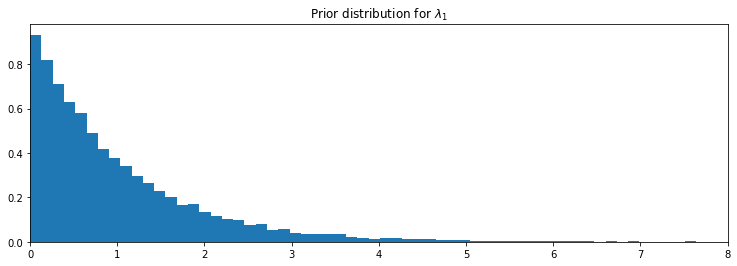

In [20]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)

samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

Q: 그렇다면 관측치를 어떻게 모형에 반영시킬까?  

- Stochastic variable의  `observed` argument를 사용
- 해당 변수의 값을 주어진 데이터로 고정시키는 역할

In [21]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## 3.3 모델링 방법

- 데이터가 어떻게 만들어 졌는지에 대한 과정을 중심으로 생각
- 내가 데이터를 다시 만든다면 어떤 과정으로 만들 것인가? 

### 문자메세지 예제

1.  "count data"가 추출될 수 있는 확률분포는 무엇인가? 
    -  Poisson 분포가 좋은 후보임
    - $C_i \sim Poi(\lambda)$


2.  포아송 분포의 모수인 $\lambda$를 알고 있는가? 
    - 모를 뿐 아니라 변환점($\tau$) 이후 달라지는 것을 가정
    $$\lambda = \left\{
\begin{matrix}
\lambda_1 & \mbox{if } t<\tau\\
\lambda_2 & \mbox{if } t\geq\tau\\
\end{matrix}
\right. $$ 

3. 두 개의  $\lambda$에 대한 적절한 확률분포는 무엇인가?
    - $\lambda$는 평균 count의 의미를 가지므로 양의 값에 대해 정의되는 분포이어야 함
    - 지수분포가 좋은 후보 
    - $\lambda_j\sim Exponential(\alpha)$ 
    

4.  지수분포의 모수인 $\alpha$를 아는가? 
    - 모름. $\alpha$에 대해 또다시 확률분포를 적용할 수도 있지만 그만큼 관심이 있지 않고 사전 정보가 별로 없음 
    - $\lambda$에 대한 사전 정보(10-30 사이의 값?)를 $\alpha$가 잘 반영하게 하기 위해 $\lambda|\alpha$의 기대값이 관측치의 평균이 되도록 설정함
$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


5. 전환점 $\tau$에 대한 정보가 없으므로 전체 일자에 대한 균등 분포로 사전분포를 설정 
\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}


모형에서 변수들 간의 관계를 아래와 같이 나타낼 수 있다.
<img src="http://i.imgur.com/7J30oCG.png" width = 700/>



In [22]:
"""## DO NOT RUN 
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)"""

'## DO NOT RUN \nwith pm.Model() as model:\n    alpha = 1.0/count_data.mean()  # Recall count_data is the\n                                   # variable that holds our txt counts\n    lambda_1 = pm.Exponential("lambda_1", alpha)\n    lambda_2 = pm.Exponential("lambda_2", alpha)\n    \n    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)\n\n    idx = np.arange(n_count_data) # Index\n    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)\n    \n    observation = pm.Poisson("obs", lambda_, observed=count_data)'

In [23]:
with pm.Model() as model:
   ## 모형 구성
    theta = pm.Beta('theta', alpha, beta)
    obs = pm.Binomial('obs', n, theta, observed `= y)


In [24]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, chains=1)

<ipython-input-24-370889a8f0a9>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=5000,step=step, chains=1)
Sequential sampling (1 chains in 1 job)
Metropolis: [theta]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 32 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [25]:
## 사후분포의 평균을 MCMC 샘플로부터 계산 
theta_samples = trace['theta']
theta_samples.mean()


0.31536456720801587

###  Example: 스포츠 경기 (이항분포-베타분포)
스포츠 경기에서 A팀이 B팀과 12번의 경기를 수행하여 3번의 승리를 거두었다. 이에 대한 이항분포의 모수를 Beta(2,2) 사전분포를 사용하여 베이지안 추론으로 추정하기 위한 모형을 구성하라. MCMC 방법을 통해 사후분포에서 추출한 이항분포 모수의 평균을 구하시오.


In [23]:
with pm.Model() as model:
   ## 모형 구성
    theta = pm.Beta('theta', 2, 2)
    obs = pm.Binomial('obs', 12, theta, observed `= 3)


In [24]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, chains=1)

<ipython-input-24-370889a8f0a9>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=5000,step=step, chains=1)
Sequential sampling (1 chains in 1 job)
Metropolis: [theta]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 32 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [25]:
## 사후분포의 평균을 MCMC 샘플로부터 계산 
theta_samples = trace['theta']
theta_samples.mean()


0.31536456720801587

아래의 Beta-binomial 모형의 사후분포와 $Beta(\alpha, \beta)$의 평균이 $\alpha/(\alpha+\beta)$라는 사실을 이용하여 위에서 계산한 사후평균이 적절한지 판단하시오. 
$$ \theta \sim Beta(\alpha, \beta)$$ 
$$ y|\theta \sim Bin(n, \theta)$$ 
$$ \theta|y \sim Beta(\alpha+y, \beta+n-y)$$


In [26]:
## 사후분포의 평균을 Beta 분포의 평균 공식을 사용하여 계산 

alpha = 2
beta = 2
n = 12
y = 3


$$𝜃|𝑦 \sim 𝐵𝑒𝑡𝑎(𝛼+𝑦,𝛽+𝑛−𝑦) = 𝐵𝑒𝑡𝑎(5,11)$$

In [27]:
# posterior = Beta(2+3, 2+12-3) = Beta(5,11)
posterior_mean = (alpha+y)/((beta+n-y)+(alpha+y)) # 5/16
posterior_mean

0.3125

### Example: 정규분포 
어느 제품 중량이 평균 100, 표준편차 2 정규분포를 따른다고 알려져 있다. 5개 제품 조사결과 98, 100, 101, 102, 103이었다. 제품의 중량 평균 추정치를 업데이트 하기 위한 베이지안 모형을 구성하라. (표준편차=2 가정) 
$$ \mu \sim N(100, 2^2)$$ 
$$ X|\mu \sim N(\mu, 2^2)$$ 


In [28]:
with pm.Model() as model:
    ## 모형 구성 
    mu = pm.Normal('mu', mu=100, sigma = 2)
    obs = pm.Normal('obs', mu, observed = [98, 100, 101, 102, 103])
    

In [29]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, chains=1)

<ipython-input-29-370889a8f0a9>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=5000,step=step, chains=1)
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 45 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [30]:
## 사후분포의 평균 계산 
trace['mu'].mean()


100.76290896207986